In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import sys
import time
from multiprocessing import Process, Pool
import warnings
warnings.simplefilter('ignore')

# Add module path to system path
module_paths = ['..', 
                # '../extern',
                '../extern/PsrPopPy',
                # '/Users/vohl/opt/miniconda3/lib/python3.9/site-packages'
                # '/Users/vohl/miniconda3/lib/python3.10/site-packages'
               ]
for module_path in module_paths:
    if os.path.abspath(os.path.join(module_path)) not in sys.path:
        sys.path.insert(0, module_path)
    
    
# For convenience
import numpy as np
import pickle

import pandas as pd

from epn_mining.main import load_states
from epn_mining.utils.io import save, load
from epn_mining.preparation import epn
from epn_mining.preparation.pulsar import Population, Observation, Pulsar, Model, Component
from epn_mining.topology import topology
from epn_mining.analysis.stats import robust_statistics, median_of_medians, median_of_stdevs, snr
from epn_mining.utils.io import state_full_location, set_state_name
from epn_mining.analysis import stats
from epn_mining.analysis.distance import (check_bound, check_min_max, check_neg)

from epn_mining.preparation.signal import (
    shift_max_to_center, 
    shift_centroid_to_center,
    rotate,
    best_alignment
)

from epn_mining.analysis import plotting

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import style, collections as mc

style.use('default')

import json
from sklearn import mixture
from scipy.stats import norm
from joblib import parallel_backend
from tqdm import tqdm

# from dtaidistance import dtw

from dtw import dtw

import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord

import gausspy.gp as gp

import copy

# Set session variables
verbose = True
state_store=True

pink = (230/255, 29/255, 95/255, 1)
blue = (47/255, 161/255, 214/255, 0.2)
blue_full = (47/255, 161/255, 214/255, 1)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
state_prefix = 'paper'
epn_metadata = load('epn_metadata', state_prefix=state_prefix)
population = load('population_agd_firstgo_0_001__1__5', state_prefix=state_prefix)

In [3]:
def gaussian(amp, fwhm, mean):
    return lambda x: amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)
    
def unravel(list):
    return np.array([i for array in list for i in array])

def _set(x, y, y_err, data:dict=None):
    if data is None:
        data = {}
    data['data_list'] = data.get('data_list', []) + [y]
    data['x_values'] = data.get('x_values', []) + [x]
    data['errors'] = data.get('errors', []) + [y_err]
    return data

def set_n_save_data(obs:Observation, data:list=None, variable='data', state_prefix='', 
                    verbose=False):
    data = _set(
        x = obs.phase, 
        y = obs.stokes_I,
        y_err = np.ones(obs.phase.size) * median_of_stdevs(obs.stokes_I),
        data = data
    )
    
    save(variable, data, state_prefix=state_prefix, verbose=verbose)

def prep_training_sets(nchannel, 
                       nspectra, 
                       rms, 
                       ncomponents, 
                       amp_lims,
                       fwhm_lims,
                       means_lims,
                       phase=None,
                       state_prefix='training',
                       verbose=True):
    
    uniform = lambda lims: np.random.uniform(lims[0], lims[1])
    normal = lambda lims: np.random.normal(lims[0], lims[1])
    
    data={}
    for ncomp in ncomponents:
        for i in range(nspectra):
            model = Model(phase=phase, rms=rms)

            for comp in range(ncomp):
                model.add_component(amplitude=uniform(amp_lims), 
                                    fwhm=uniform(fwhm_lims), 
                                    mean=normal(means_lims))

            data['data_list'] = data.get('data_list', []) + [model.model]
            data['x_values'] = data.get('x_values', []) + [model.phase]
            data['errors'] = data.get('errors', []) + [np.ones(model.phase.size) * model.rms]
            data['amplitudes'] = data.get('amplitudes', []) + [model.amplitudes]
            data['fwhms'] = data.get('fwhms', []) + [model.fwhms]
            data['means'] = data.get('means', []) + [model.means]

    filename = save(f"{np.min(ncomponents)}_{np.max(ncomponents)}_components", 
                    data, 
                    state_prefix=state_prefix,
                    verbose=verbose, 
                    return_filename=True)
    
    return data, filename

def autonomous_gaussian_decomposition(state_prefix='', 
                                      variable='observation', 
                                      alpha1=1., 
                                      alpha2=None,
                                      snr_thresh=5.,
                                      p_width=None,
                                      drop_width=None,
                                      return_data=True,
                                      train=False,
                                      verbose=False):    
    # init
    g = gp.GaussianDecomposer()

    # AGD parameters
    g.set('phase', 'one' if alpha2 is None else 'two')
    g.set('SNR_thresh', [snr_thresh, snr_thresh])
    g.set('alpha1', alpha1)
    if alpha2 is not None:
        g.set('alpha2', alpha2)
    if p_width is not None:
        g.set('p_width', p_width)
    if drop_width is not None:
        g.set('drop_width', p_width)
        
    # decompose
    data_decomp = g.batch_decomposition(
        science_data_path=state_full_location(state_prefix, variable)
    )

    # save(set_state_name(variables=f'decomp', 
    #                     state_prefix=variable), 
    #      data_decomp, 
    #      state_prefix=state_prefix,
    #      verbose=verbose)
    return data_decomp


In [ ]:
jname = 'J0534+2200'
f = 5

pulsar = population.pulsars[jname]
obs = pulsar.observations[f]

obs.model = model
obs.model = np.max([obs.model, model], axis=0)
obs.model_agd['note'] = 'Model is currently set as the maximum value between AGD and DPGMM models using np.max([obs.model, model], axis=0)'

save('population_agd_firstgo_0_001__1__5', population, state_prefix=state_prefix)

freqs_to_include = [2, 3, 4, 5]
verbose=False
for pulsar in tqdm(population.as_array()[37:]):
    for f in freqs_to_include:
        obs = pulsar.observations[f]# Fit observations with poor fits

In [ ]:
freqs_to_include = [2, 3, 4, 5]
verbose=False

print ('Name\t\tFreq\tS/N\tchi_2')
for pulsar in population.as_array()[37:]:
    for i, f in enumerate(freqs_to_include):
        obs = pulsar.observations[f]
        plt.scatter(obs.snr,
                    obs.model_agd['best_fit_rchi2'][0][0])
        print (
            "{}\t{:.0f}\t{:.0f}\t{:.4f}".format(
                pulsar.jname,
                obs.frequency,
                obs.snr,
                obs.model_agd['best_fit_rchi2'][0][0]
            ) if i == 0 else "\t\t{:.0f}\t{:.0f}\t{:.4f}".format(
                obs.frequency,
                obs.snr,
                obs.model_agd['best_fit_rchi2'][0][0]
            )            
        )
    print ()
        
plt.yscale('log')
plt.xscale('log')
plt.xlabel('S/N')
plt.ylabel(r'$\chi^2$')
        

In [ ]:
jname = 'J0534+2200'
f = 5

pulsar = population.pulsars[jname]
obs = pulsar.observations[f]

fig, ax = plt.subplots(1,1)

for i, (mu, fwhm, amp) in enumerate(zip(
    unravel(obs.model_agd['means_fit']),
    unravel(obs.model_agd['fwhms_fit']),
    unravel(obs.model_agd['amplitudes_fit']),
)): 
    component = gaussian(amp, fwhm, mu)(obs.phase)
    model = component if i==0 else model + component
    ax.plot(obs.phase, component, color='lightgrey', alpha=0.8)

ax.plot(obs.phase, obs.model, color=blue_full)
# ax.plot(obs.phase, obs.model, color=pink, linestyle='--', linewidth=.5)


ax.plot(obs.phase, obs.stokes_I, color='black', linestyle=':', zorder=1000)

# ax.plot(obs.phase, 
#         obs.stokes_V, color='blue', alpha=0.8)
# ax.plot(obs.phase,
#         obs.stokes_L, color='red', alpha=0.8)

ax.set_title(f"{obs.frequency:.0f}MHz ({obs.epn_reference_code}) S/N:{obs.snr:.0f} chi2:{unravel(obs.model_agd['best_fit_rchi2'])[0]:.2f}")
ax.annotate(f"n: {len(unravel(obs.model_agd['means_fit']))}", xy=(0.6, 0.8), xycoords='axes fraction')
plt.suptitle(
    f"{pulsar.jname} [{pulsar.bname}]"
)

0.0001


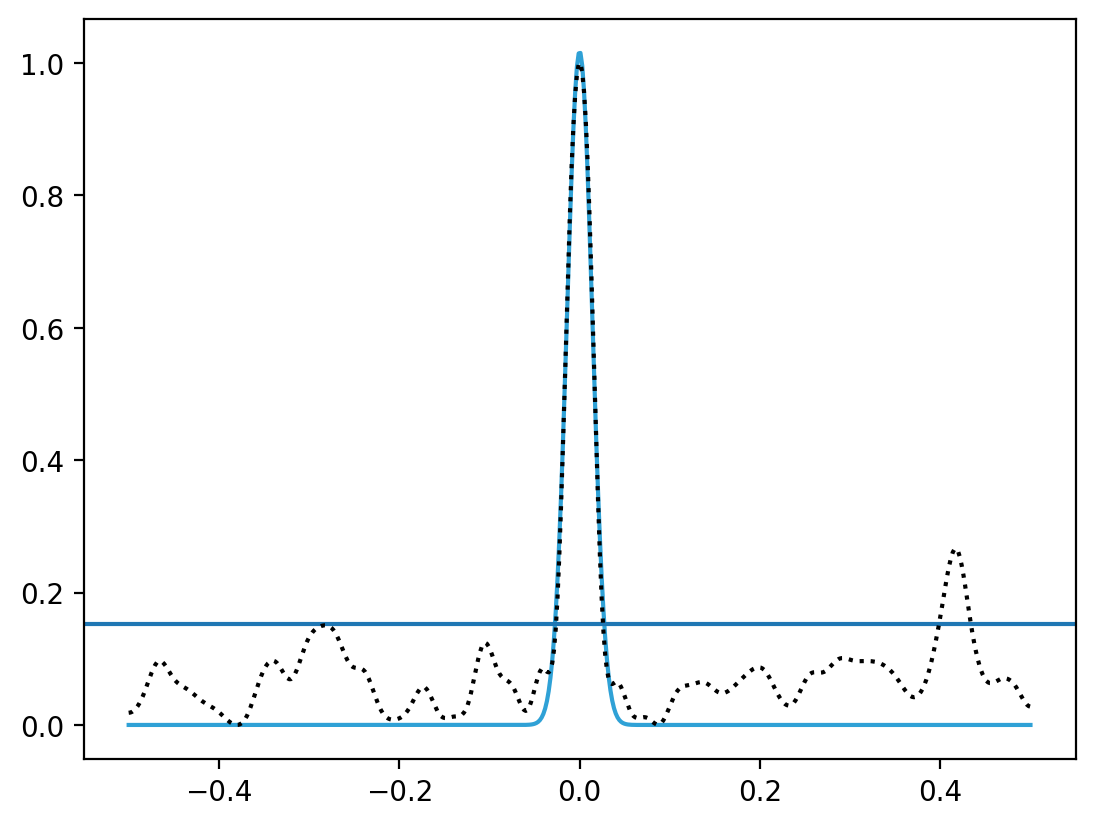

In [5]:
jname = 'J0534+2200'
f = 5

pulsar = population.pulsars[jname]
obs = pulsar.observations[f]

ax = plt.subplot()

ax.plot(obs.phase, obs.model, color=blue_full)
ax.plot(obs.phase, obs.stokes_I, color='black', linestyle=':', zorder=1000)

# ax.plot(obs.phase, 
#         obs.stokes_V, color='blue', alpha=0.8)
# ax.plot(obs.phase,
#         obs.stokes_L, color='red', alpha=0.8)

# ax.axhline(median_of_medians(obs.stokes_I) + (5*median_of_stdevs(obs.stokes_I)))
ax.axhline(median_of_medians(obs.stokes_I) + 2.5*median_of_stdevs(obs.stokes_I))

print (obs.model_agd['alpha1'])
# print (obs.model_agd['alpha2'])

Saved to states/paper_observation_minsnr_2.pickle


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [21:27<00:00,  1.29s/it]


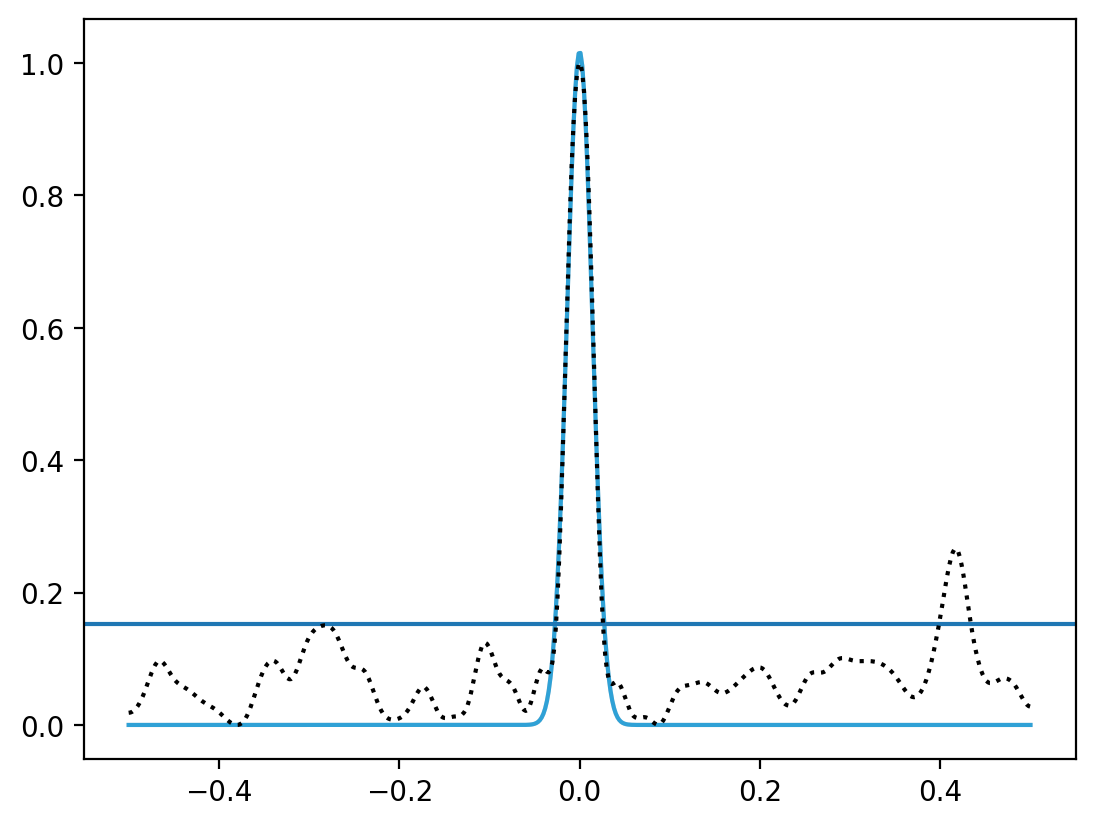

In [8]:
# most fits were run with         for alpha in tqdm(np.arange(0.001, 5., .05))

snr_thresh = 2.5
variable = f'observation_minsnr_{snr_thresh:.0f}'

set_n_save_data(obs, 
                variable=variable, 
                state_prefix=state_prefix,
                verbose=verbose)

alpha_grid = {
    f"{alpha:.3f}": autonomous_gaussian_decomposition(state_prefix=state_prefix, 
                                                      variable=variable, 
                                                      alpha1=0.025,
                                                      alpha2=alpha,
                                                      snr_thresh=snr_thresh,
                                                      verbose=False) \
    for alpha in tqdm(np.arange(0.0001, 1, .001))
}

a_i = np.argmin([alpha_grid[a]['best_fit_rchi2'][0][0] if alpha_grid[a]['best_fit_rchi2'][0] is not None else 10000 for a in alpha_grid.keys()])
alpha1 = list(alpha_grid.keys())[a_i]

# obs.model_agd = alpha_grid[alpha1]
# obs.model_agd['alpha1'] = alpha1

model_agd = alpha_grid[alpha1]

# alpha1 = float(list(alpha_grid.keys())[a_i])

# alpha_grid = {
#     f"{alpha:.4f}": autonomous_gaussian_decomposition(state_prefix=state_prefix, 
#                                                variable=variable, 
#                                                alpha1=alpha1,
#                                                alpha2=alpha,
#                                                snr_thresh=snr_thresh,
#                                                verbose=False) \
#     for alpha in tqdm(np.arange(0.0001, 0.01, .0005))
# }

# # a_i = np.argmin([alpha_grid[a]['best_fit_rchi2'][0][0] for a in alpha_grid.keys()])
# a_i = np.argmin([alpha_grid[a]['best_fit_rchi2'][0][0] if alpha_grid[a]['best_fit_rchi2'][0] is not None else 10000 for a in alpha_grid.keys()])
# alpha2 = list(alpha_grid.keys())[a_i]



ax = plt.subplot()

for i, (mu, fwhm, amp) in enumerate(zip(
    unravel(model_agd['means_fit']),
    unravel(model_agd['fwhms_fit']),
    unravel(model_agd['amplitudes_fit']),
)): 
    component = gaussian(amp, fwhm, mu)(obs.phase)
    model = component if i==0 else model + component
    ax.plot(obs.phase, component, color='lightgrey', alpha=0.8)

ax.plot(obs.phase, model, color=blue_full)
ax.plot(obs.phase, obs.stokes_I, color='black', linestyle=':', zorder=1000)

ax.axhline(median_of_medians(obs.stokes_I) + 2.5*median_of_stdevs(obs.stokes_I))



In [9]:
alpha1

'0.000'

In [ ]:
obs.model_agd = alpha_grid[alpha1]
obs.model_agd['alpha1'] = alpha1
# obs.model_agd['alpha2'] = alpha2

In [ ]:
alpha1, alpha2

In [ ]:
obs.set_model(scale=True)

In [ ]:
alpha_grid.keys()

In [ ]:
alpha1

In [ ]:
alpha1

In [ ]:
autonomous_gaussian_decomposition(state_prefix=state_prefix, 
                                               variable=variable, 
                                               alpha1=0.001,
                                               alpha2=0.0001,
                                               p_width=0.5, 
                                               drop_width=0.5,
                                               snr_thresh=1,
                                               verbose=False)

In [ ]:
to_shift = 'J1705-1906'

